In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P38DR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 25667 × 53801
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'cluster', 'Type', 'Subclass', 'Class_broad'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 5165 × 53801
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'cluster', 'Type', 'Subclass', 'Class_broad'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

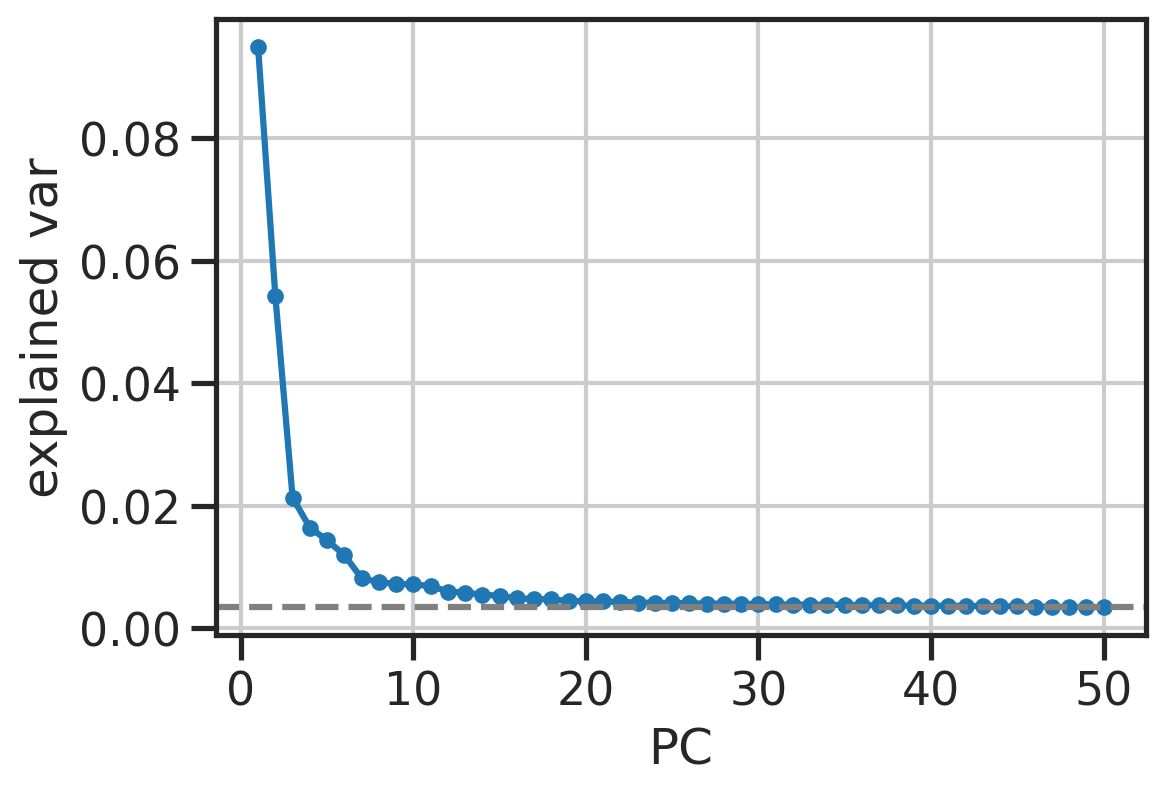

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

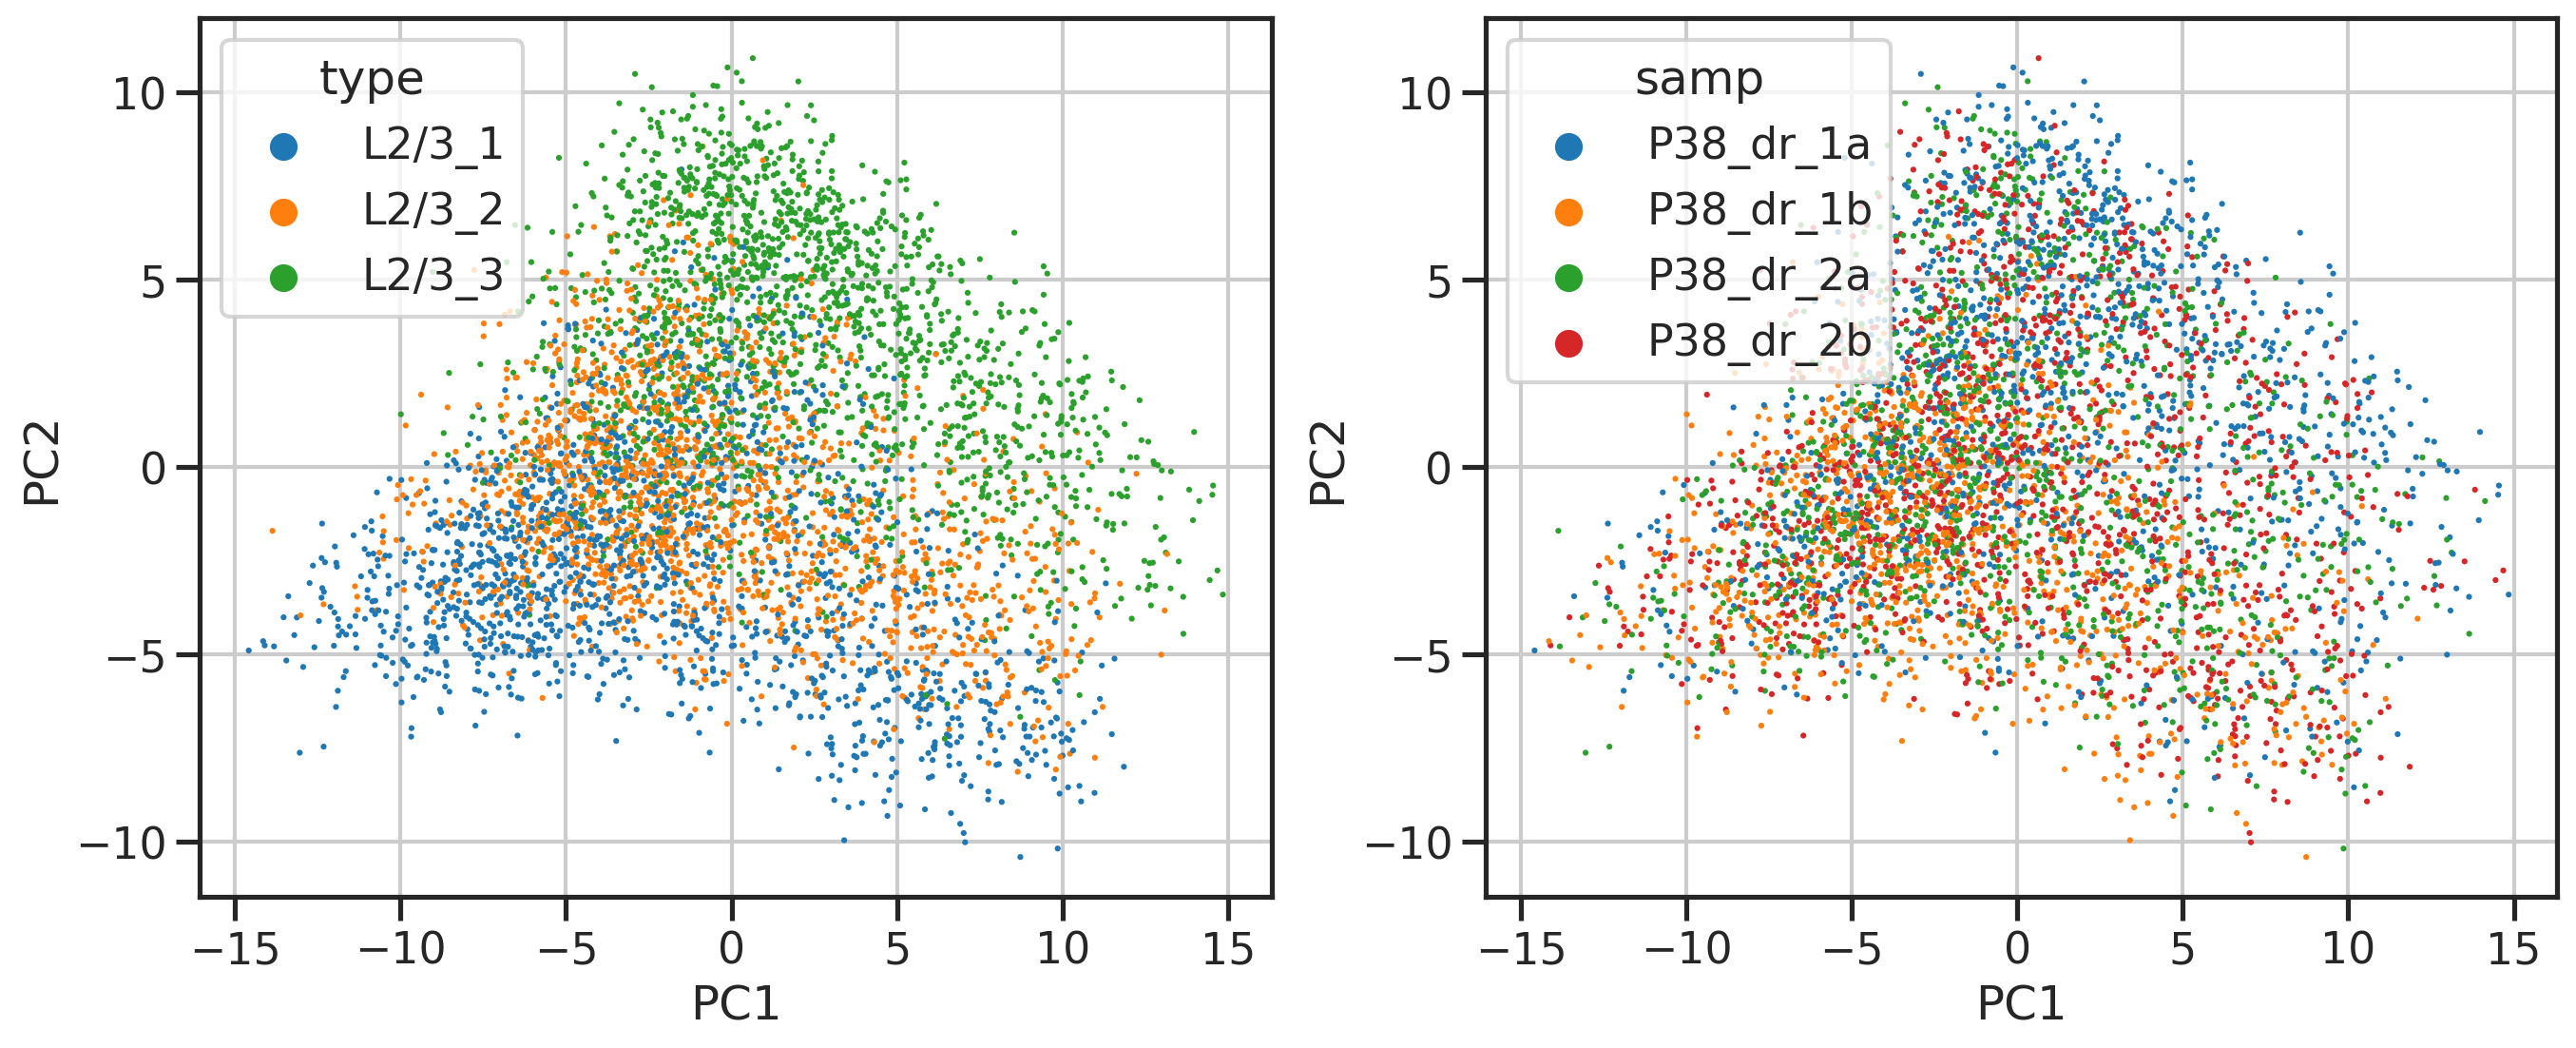

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

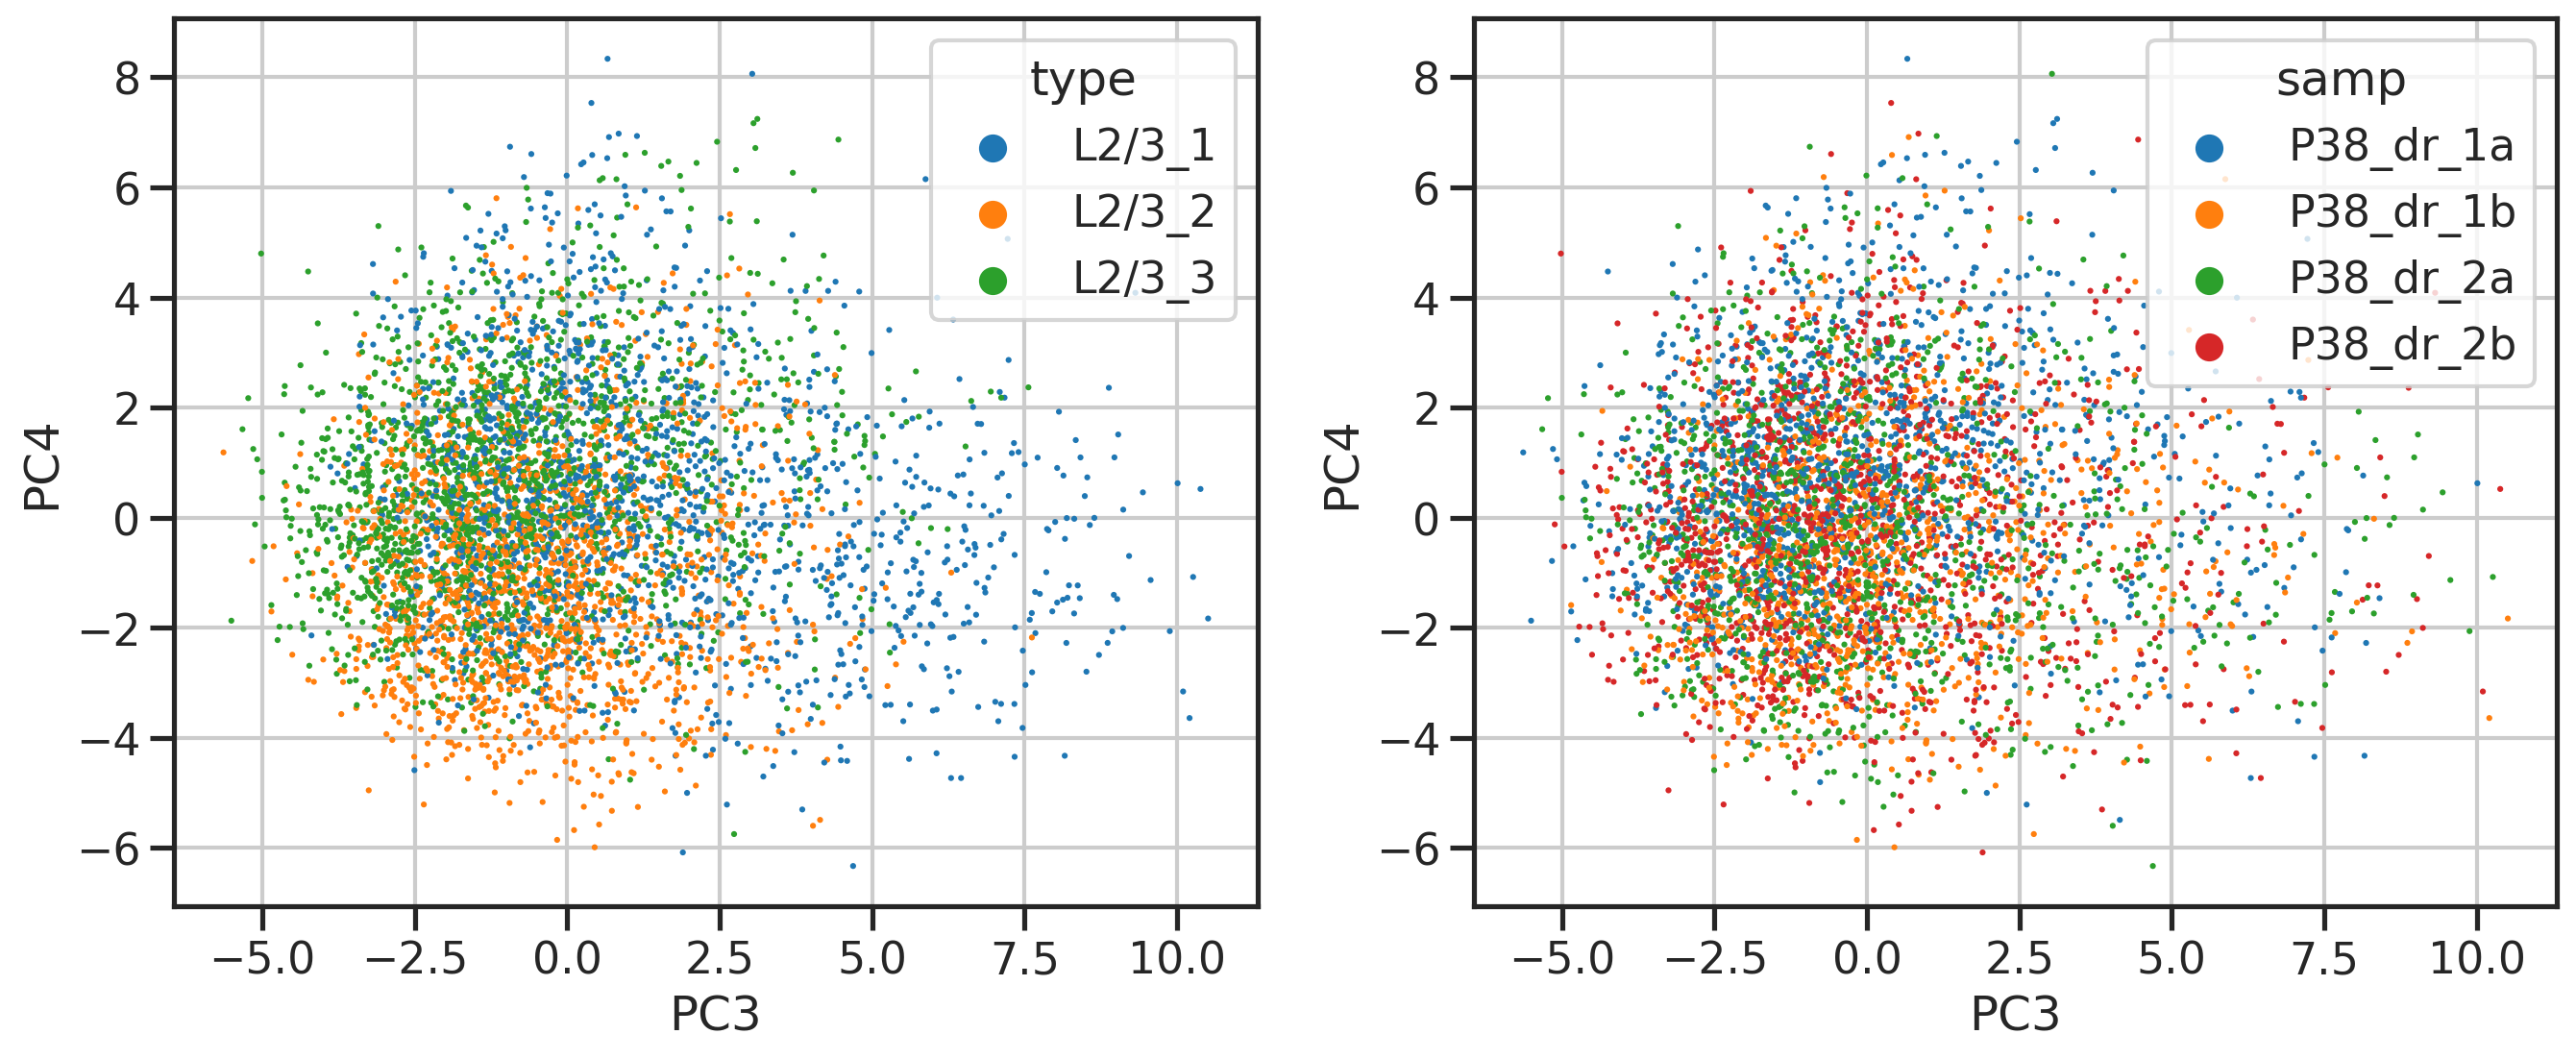

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

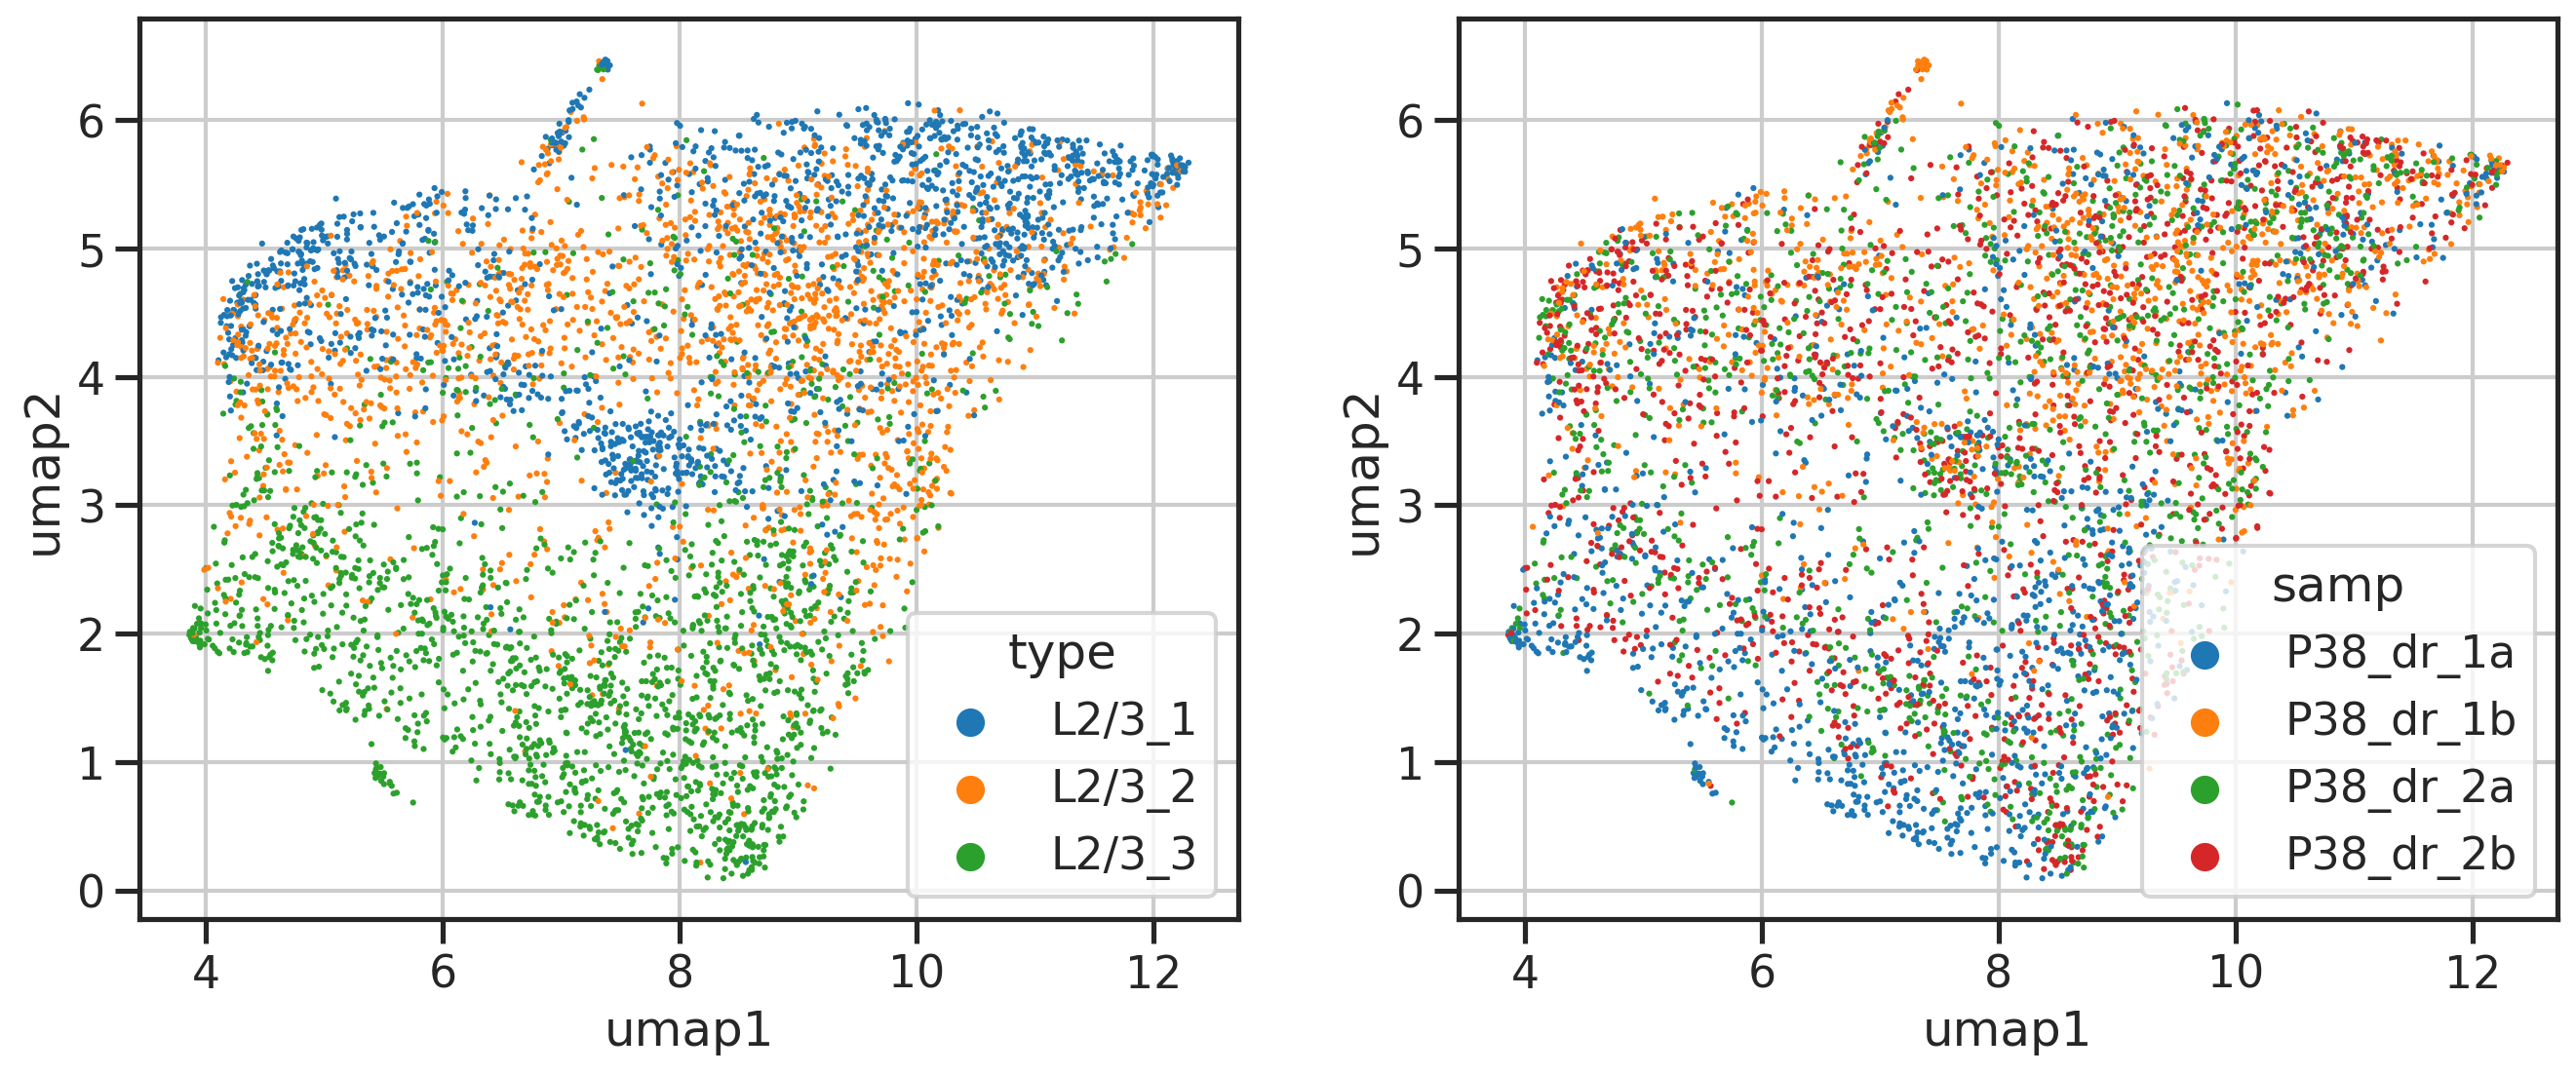

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

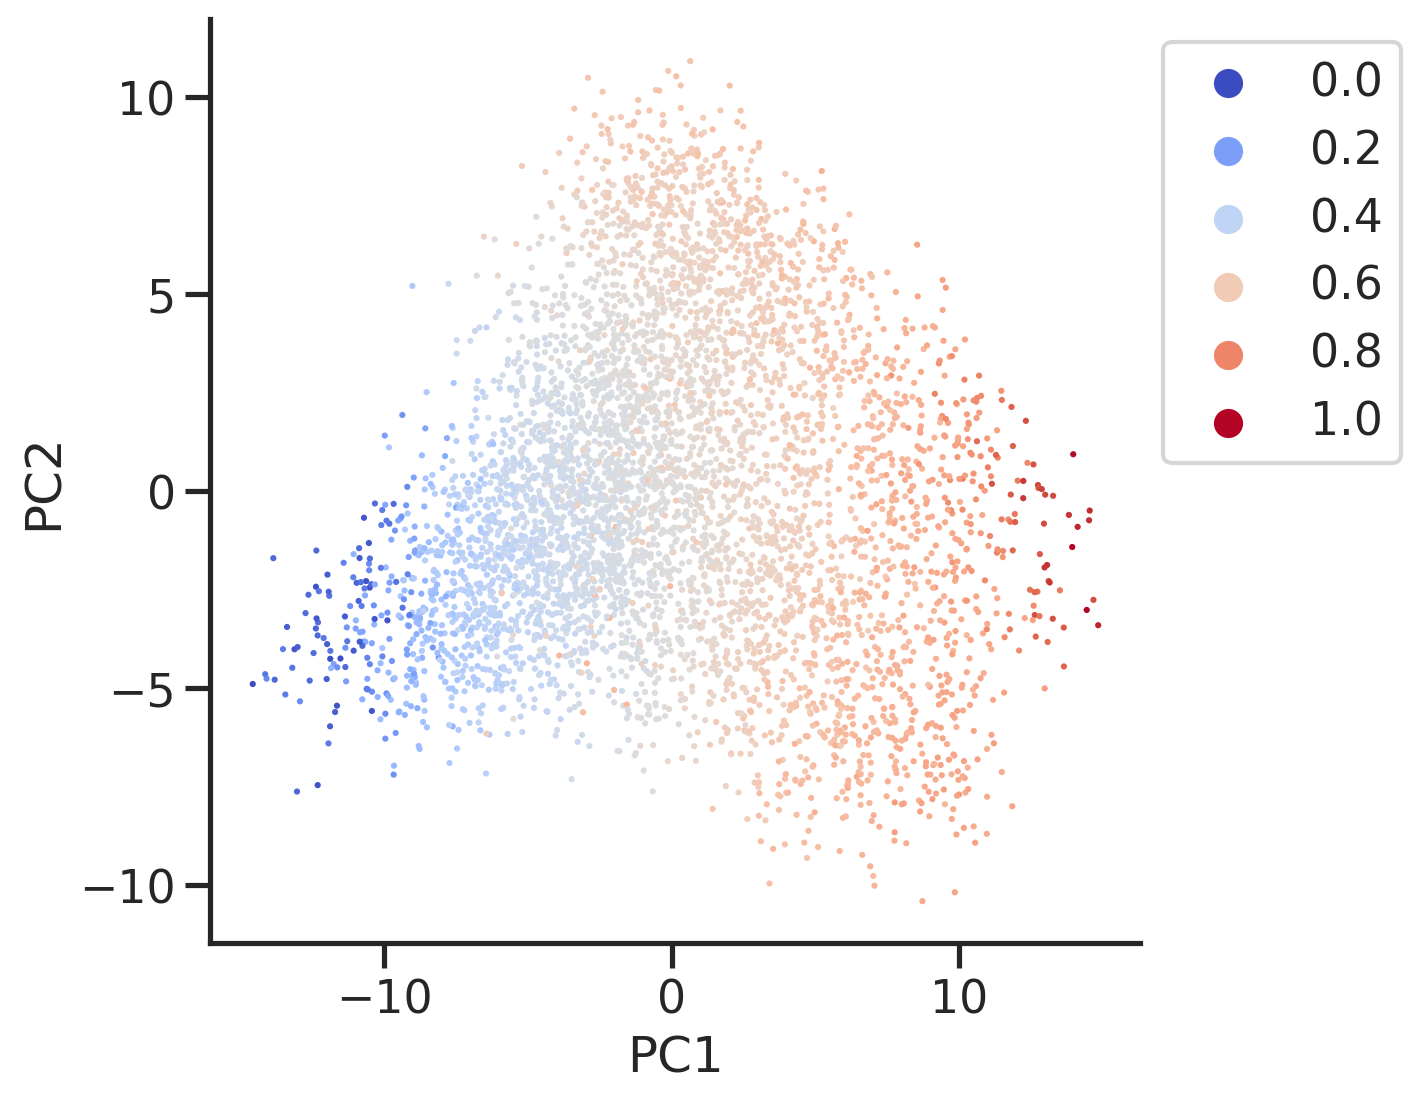

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:07:09 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


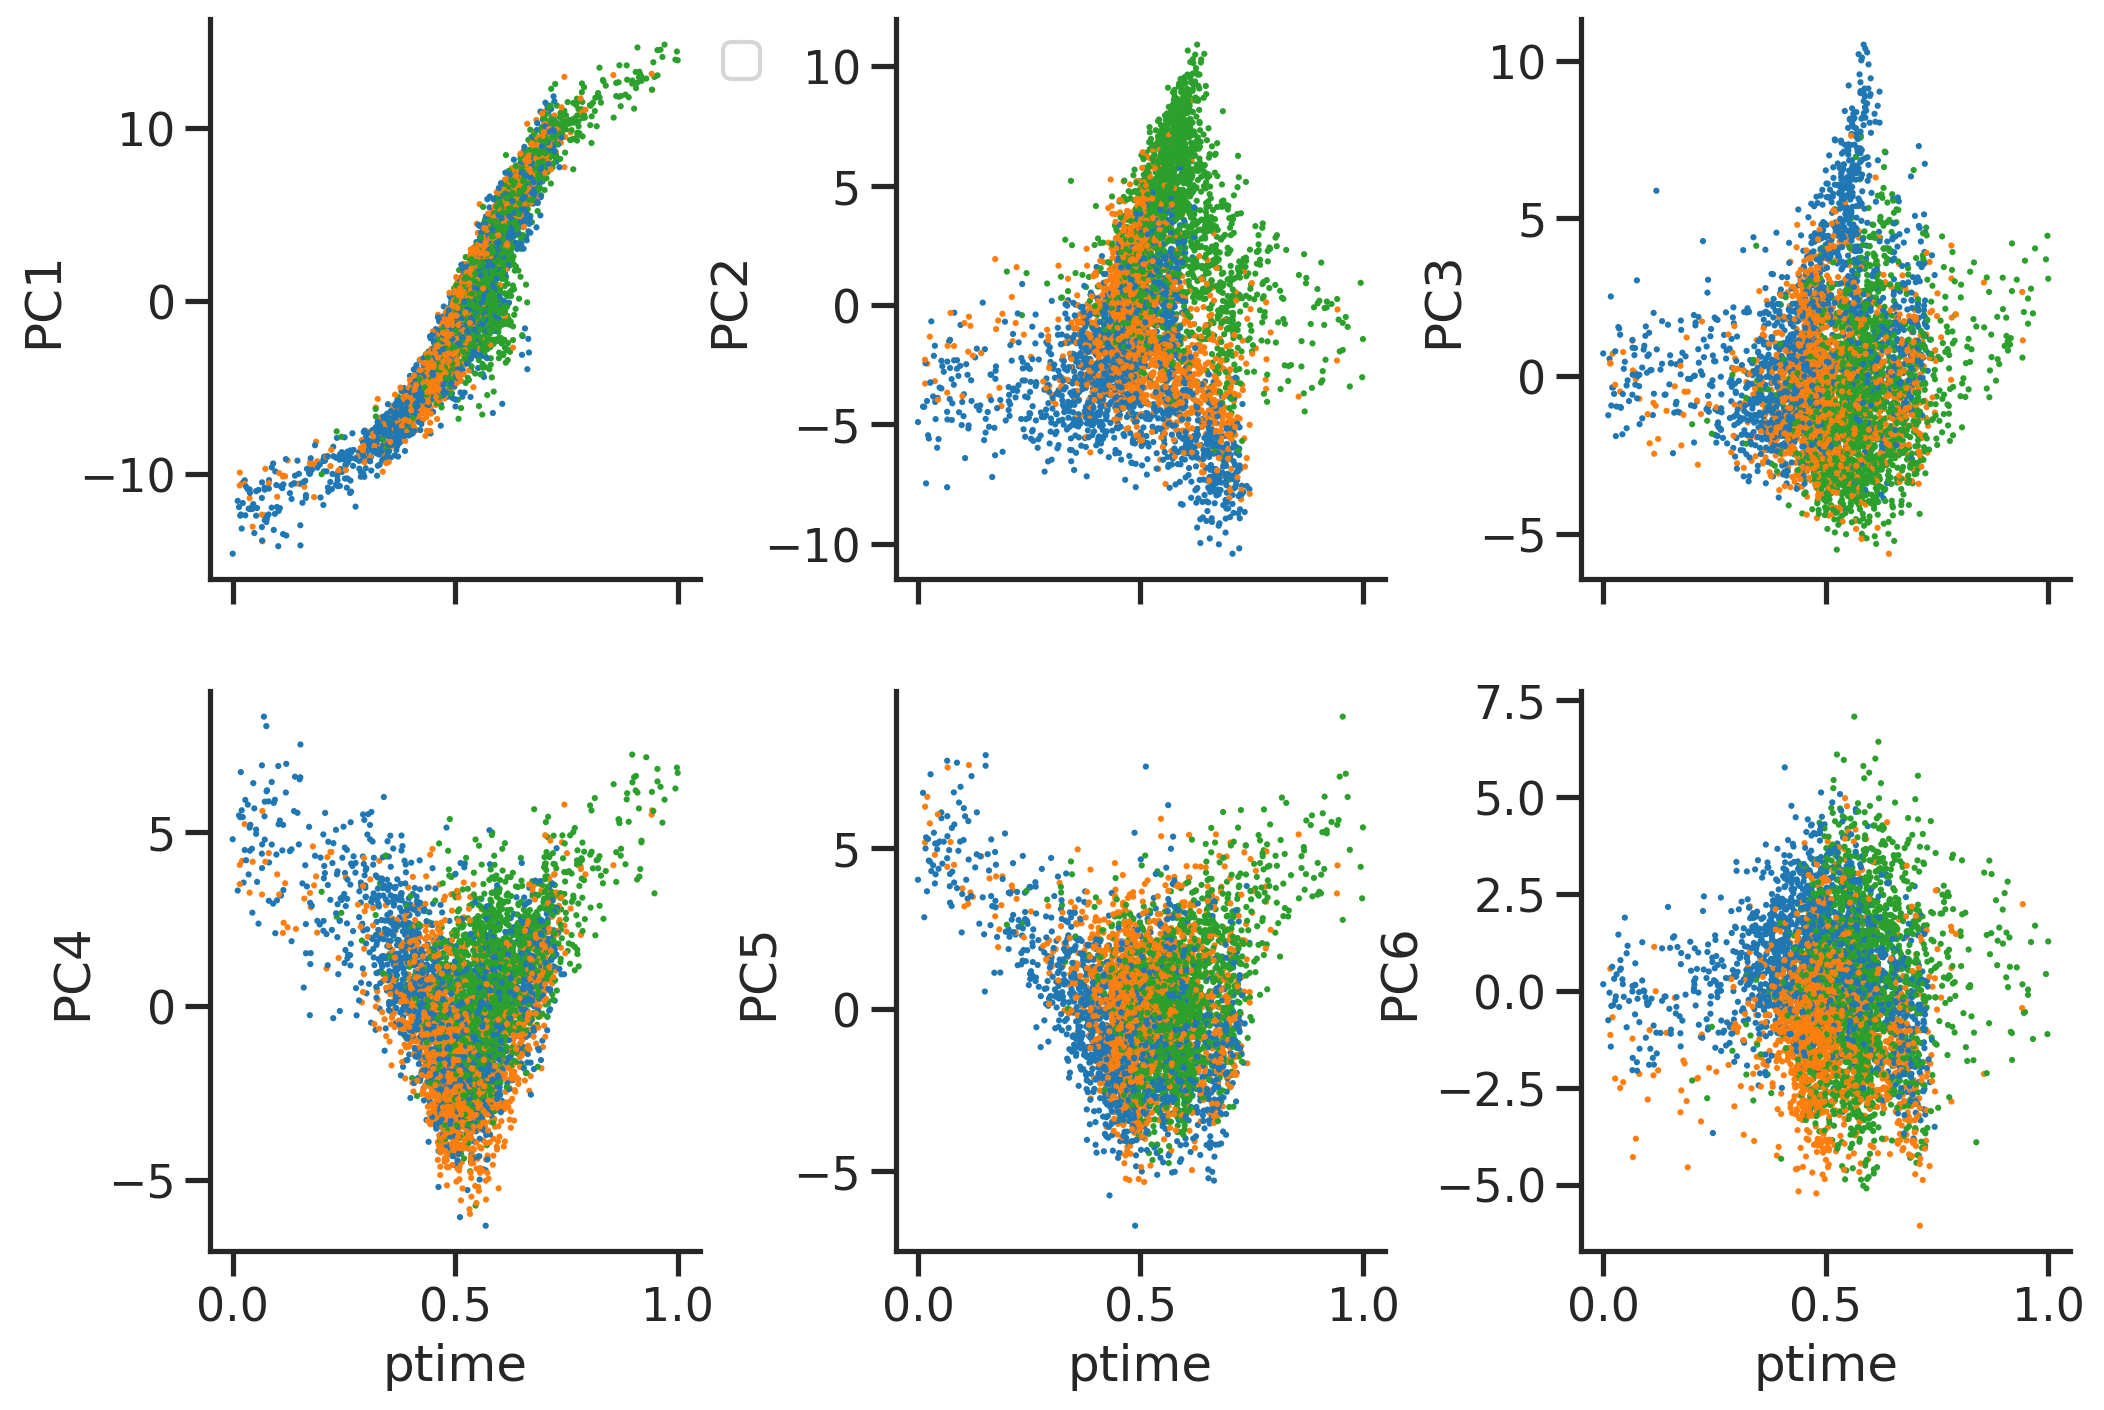

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:07:15 - maxp pruned
03-28 14:07:15 - cmap pruned
03-28 14:07:15 - kern dropped
03-28 14:07:15 - post pruned
03-28 14:07:15 - FFTM dropped
03-28 14:07:15 - GPOS pruned
03-28 14:07:15 - GSUB pruned
03-28 14:07:15 - name pruned
03-28 14:07:15 - glyf pruned
03-28 14:07:15 - Added gid0 to subset
03-28 14:07:15 - Added first four glyphs to subset
03-28 14:07:15 - Closing glyph list over 'GSUB': 35 glyphs before
03-28 14:07:15 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'P', 'R', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:07:15 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 39, 42, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:07:15 - Closed glyph list over 'GSUB': 35 glyphs after
03-28 14:07:15 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'P', 'R'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P38DR_v4_2023-03-28.pdf


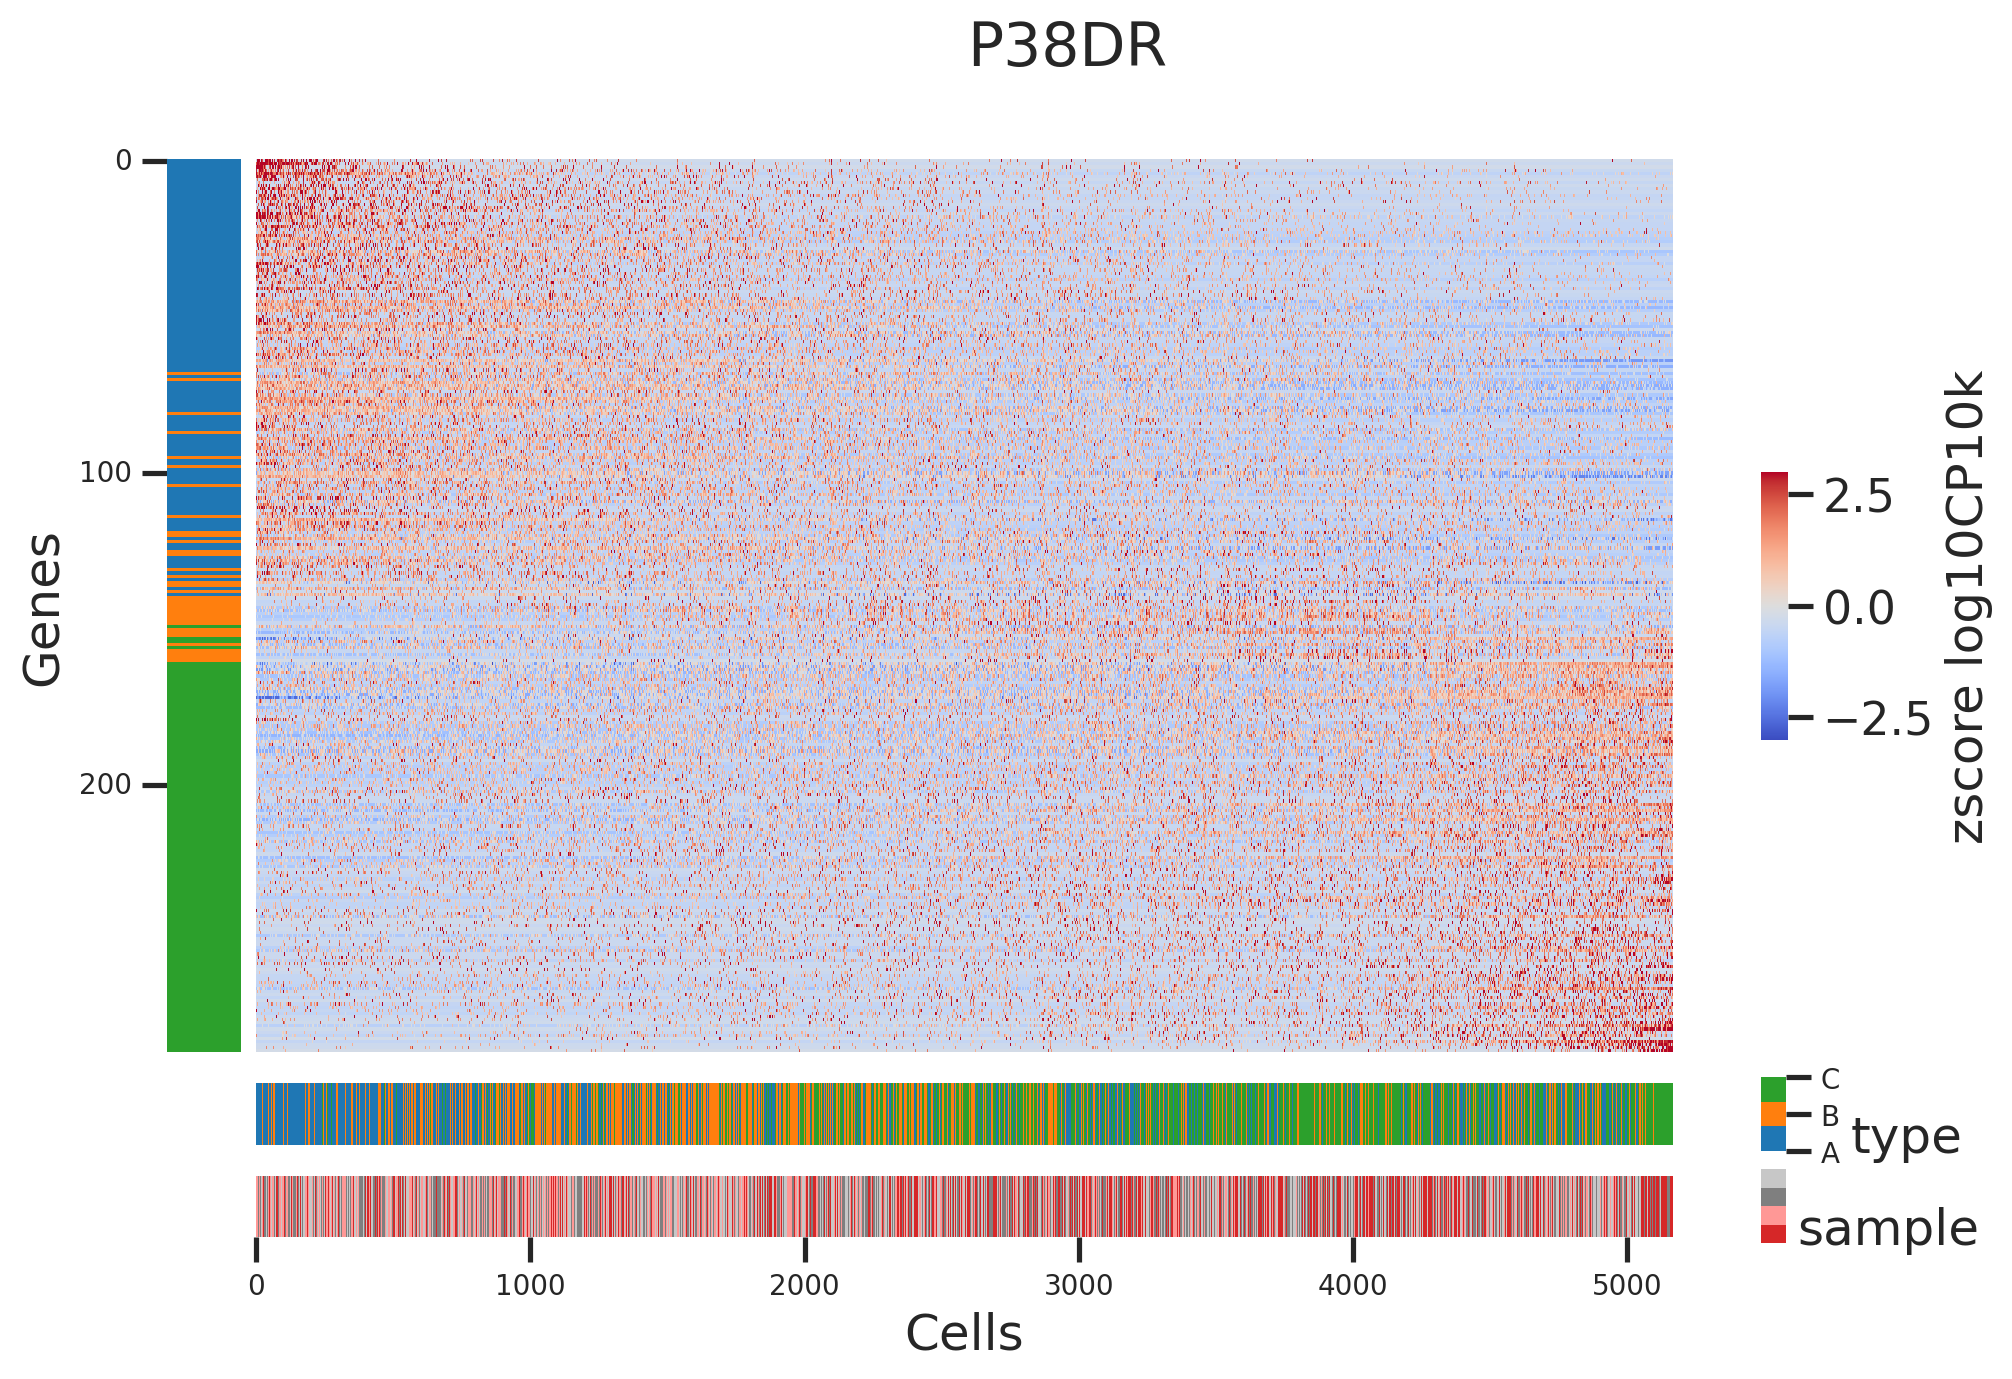

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCAAGCGCTGCT-1-P38_dr_1a  2.035125  7.686991 -0.166150 -1.411172   
AAACCCAAGTCGTCTA-1-P38_dr_2a -0.045708  8.628153 -0.156638  0.012244   
AAACCCAAGTGCACCC-1-P38_dr_1b -6.012995  4.549356 -0.155136  0.449627   
AAACCCACAGAGTAAT-1-P38_dr_1a  4.947984  6.337540  0.096841  0.825196   
AAACCCAGTGTAACGG-1-P38_dr_1b  9.202987 -7.681468  7.292674  1.171831   
...                                ...       ...       ...       ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a  1.603377  2.800474  1.054118 -2.621499   
TTTGGTTTCTGCCTGT-1-P38_dr_2b -3.830772  7.694133 -0.449819  2.001263   
TTTGTTGCACCGGTCA-1-P38_dr_2a -2.635137  4.027407 -1.084643  1.620008   
TTTGTTGGTGGCTAGA-1-P38_dr_2b -1.907812  0.440405 -0.632879  0.026408   
TTTGTTGTCTATTGTC-1-P38_dr_1a -1.354609  4.176123 -2.011386  0.610003   

                                   PC5       PC6       PC7       PC8  \
AAACCCAAGCGCTGCT-1-P38_dr_1a  1.180937  1.815701  1.118950  1.316729   
AAACCCAAGTCGTCTA-1-P38_dr_2a -0.222760 -2.076709 -0.555571  1.127777   
AAACCCAAGTGCACCC-1-P38_dr_1b  2.621418 -2.244303 -1.414748  1.480317   
AAACCCACAGAGTAAT-1-P38_dr_1a  3.100001  2.005085 -1.980965 -2.898241   
AAACCCAGTGTAACGG-1-P38_dr_1b  0.429499 -2.350924  3.225203  4.412540   
...                                ...       ...       ...       ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a  1.496856  3.133421 -0.524684  1.361778   
TTTGGTTTCTGCCTGT-1-P38_dr_2b  1.363460 -3.604184  2.277025  2.689968   
TTTGTTGCACCGGTCA-1-P38_dr_2a -0.744443 -0.695006  0.090084  3.042968   
TTTGTTGGTGGCTAGA-1-P38_dr_2b -1.893107 -2.452266 -0.529140 -0.347105   
TTTGTTGTCTATTGTC-1-P38_dr_1a -1.731325 -0.013117  1.008741 -1.432405   

                                   PC9      PC10  ...      PC46      PC47  \
AAACCCAAGCGCTGCT-1-P38_dr_1a  1.238087  1.161746  ... -0.371501  0.642635   
AAACCCAAGTCGTCTA-1-P38_dr_2a -0.545282  3.483192  ... -0.058866 -1.127699   
AAACCCAAGTGCACCC-1-P38_dr_1b -0.552487  0.475024  ...  0.726496  0.199453   
AAACCCACAGAGTAAT-1-P38_dr_1a -1.882314  1.619925  ...  0.235977 -0.212931   
AAACCCAGTGTAACGG-1-P38_dr_1b  1.306930  1.621817  ...  1.183348 -1.665669   
...                                ...       ...  ...       ...       ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a -0.675490 -1.652105  ...  1.270295  0.693891   
TTTGGTTTCTGCCTGT-1-P38_dr_2b -1.778446  1.101287  ... -0.918216  0.812298   
TTTGTTGCACCGGTCA-1-P38_dr_2a -0.855017 -1.101044  ...  0.209971 -1.234141   
TTTGTTGGTGGCTAGA-1-P38_dr_2b  0.620726  0.776882  ... -0.206951  0.859818   
TTTGTTGTCTATTGTC-1-P38_dr_1a  0.625728 -2.562805  ... -0.662818 -0.282952   

                                  PC48      PC49      PC50    type       samp  \
AAACCCAAGCGCTGCT-1-P38_dr_1a -1.078123  0.919577  1.010561  L2/3_3  P38_dr_1a   
AAACCCAAGTCGTCTA-1-P38_dr_2a -0.582772  0.823621 -0.240859  L2/3_3  P38_dr_2a   
AAACCCAAGTGCACCC-1-P38_dr_1b -0.773131 -0.845740 -0.182927  L2/3_3  P38_dr_1b   
AAACCCACAGAGTAAT-1-P38_dr_1a -1.985069 -0.338562  0.329567  L2/3_3  P38_dr_1a   
AAACCCAGTGTAACGG-1-P38_dr_1b -0.231724 -0.040195 -0.242208  L2/3_1  P38_dr_1b   
...                                ...       ...       ...     ...        ...   
TTTGGTTCAGTTGTTG-1-P38_dr_1a  0.494570  0.283097 -0.610193  L2/3_3  P38_dr_1a   
TTTGGTTTCTGCCTGT-1-P38_dr_2b  1.058447  0.135438 -0.950601  L2/3_3  P38_dr_2b   
TTTGTTGCACCGGTCA-1-P38_dr_2a  0.170709  0.457045  0.846405  L2/3_3  P38_dr_2a   
TTTGTTGGTGGCTAGA-1-P38_dr_2b  0.117613 -0.129171 -0.410174  L2/3_2  P38_dr_2b   
TTTGTTGTCTATTGTC-1-P38_dr_1a -0.028338  0.522932 -0.591497  L2/3_2  P38_dr_1a   

                                 umap1     umap2     ptime  
AAACCCAAGCGCTGCT-1-P38_dr_1a  7.641355  0.987286  0.583165  
AAACCCAAGTCGTCTA-1-P38_dr_2a  8.709404  0.702251  0.576362  
AAACCCAAGTGCACCC-1-P38_dr_1b  9.963480  2.400154  0.436035  
AAACCCACAGAGTAAT-1-P38_dr_1a  5.763034  1.123917  0.668959  
AAACCCAGTGTAACGG-1-P38_dr_1b  4.441137  4.230407  0.709224  
...                                ...   

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)